# **PRÁCTICA 2: AUTOENCODERS - Parte 2: Convolucionales**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos

## **Ejercicio 3: Aplícalo para detección de anomalías**

**Codificador automático convolucional**

<p align="justify">Dado que nuestras entradas son imágenes, tiene sentido utilizar redes neuronales convolucionales (convnets) como codificadores y decodificadores. En entornos prácticos, los codificadores automáticos aplicados a las imágenes son siempre codificadores automáticos convolucionales, simplemente funcionan mucho mejor.</p>

<p align="justify">Implementemos uno. El codificador consistirá en una pila de capas Conv2Dy MaxPooling2D(la agrupación máxima se utiliza para el muestreo descendente espacial), mientras que el decodificador consistirá en una pila de capas Conv2Dy .UpSampling2D.</p>

<p align="justify">Es decir, comenzaremos de manera simple, con una sola capa neuronal completamente conectada como codificador y decodificador:</p>

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# MODELO

# ENCODER activity_regularizer (parámentro de las Dense); activity_regularizer = regularizers.l1(0.01)
input_img = Input(shape=(28, 28, 1))  
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# DECODER
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


In [3]:
opt = Adam(learning_rate=0.0001)
autoencoder0 = Model(input_img, decoded)
autoencoder0.compile(optimizer=opt, loss='mse')

In [4]:
autoencoder0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

<p align="justify">Para entrenarlo, usaremos los dígitos MNIST originales:</p>

In [5]:
# DATOS
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

11490434/11490434 [==============================] - 0s 0us/step


<p align="justify">Entrenemos este modelo durante 100 épocas.</p>

In [6]:
# ENTRENAMIENTO
from keras.callbacks import TensorBoard

autoencoder0.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 13s 7ms/step - loss: 0.1060 - val_loss: 0.0567
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0479 - val_loss: 0.0421
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0393 - val_loss: 0.0364
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0348 - val_loss: 0.0325
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0314 - val_loss: 0.0295
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0287 - val_loss: 0.0272
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0266 - val_loss: 0.0254
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0250 - val_loss: 0.0240
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0238 - val_loss: 0.0229
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0228 - val_l

<p align="justify">Después de 100 épocas, el codificador automático parece alcanzar un valor de pérdida de validación/entrenamiento estable de aproximadamente 0.0122. Podemos intentar visualizar las entradas reconstruidas y las representaciones codificadas. Usaremos Matplotlib en el siguiente apartado.</p>

<p align="justify">Ahora realizamos los mismos pasos que en los apartados de la Parte 1 de detección de anomalías.</p>

In [7]:
decoded_imgs3 = autoencoder0.predict(x_test)
error_tes = np.mean(np.abs(x_test-decoded_imgs3)**2,tuple(range(1, decoded_imgs3.ndim)))

313/313 [==============================] - 1s 2ms/step


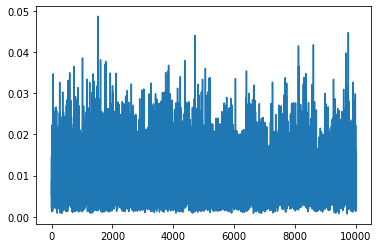

In [8]:
%matplotlib inline
plt.figure
plt.plot(error_tes,label="error_test")

In [9]:
#Seleccionar el threshold a partir del error de reconstrucción (por ejemplo  error_test > 0.04)
img_anomala=error_tes>0.035
# Nos devuelve los indices que dan TRUE
index_anomalies=np.where(img_anomala)[0]
print(index_anomalies)

[ 744 1017 1526 1609 1758 1782 3749 3817 3846 4376 4713 5054 6403 8112
 8116 8602 9672 9750]


<p align="justify">Mostramos las imágenes con mayor error de reconstrucción en la base de datos.</p>

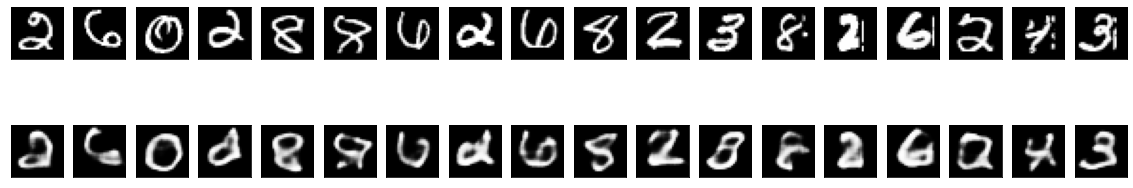

In [10]:
import matplotlib.pyplot as plt

j=0
plt.figure(figsize=(20, 4))
for i in index_anomalies:
    # display original
    ax = plt.subplot(2, len(index_anomalies), j + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, len(index_anomalies), j + 1 + len(index_anomalies))
    plt.imshow(decoded_imgs3[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=j+1
plt.show()